In [79]:
import os
import json
import numpy as np
import pandas as pd
import pyarrow as pa
import nltk
import matplotlib.pyplot as plt

In [4]:
labels = pd.read_parquet('labels.gzip')
usage_data_df = pd.read_parquet('usage_df.gzip')
main_df = pd.read_parquet('main_df.gzip')
country_rank_df = pd.read_parquet('country_rank_df.gzip')
domain_df = pd.read_parquet('owned_domain_df.gzip')
contr_subdom_df = pd.read_parquet('contributing_subdomain_df.gzip')
category_df = pd.read_parquet('category_df.gzip')
lev_df = pd.read_parquet('lev_df.gzip')

In [4]:
#main_df = pd.read_parquet('main_df.gzip')
main_df.dtypes

requestID                        object
status_code                      object
adult_content                   float64
url_text                         object
url_type                         object
lang_encoding                    object
lang_locale                      object
links_in_count                  float64
description                      object
online_since             datetime64[ns]
title                            object
load_speed_percentile           float64
category_path                    object
category                         object
rank                            float64
alexa_rank                      float64
indicator                        object
success                            bool
unsafe                          float64
dtype: object

In [52]:
main_df['unsafe'].drop_duplicates()

0      1.0
113    0.0
514    NaN
Name: unsafe, dtype: float64

In [9]:
#can drop alexa_rank as it seems to be completley empty
#url_type seems to be canonical or None so possibly turn it binary

#### main_df columns
- requestID-----------------                        string of format: x{8}-x{4}-x{4}-x{4}-x{12}
- status_code---------------         string: 'Success','Error', or None - does not neccesarily match the success column 
- adult_content-------------                   float64: 1 for yes, 0 for no, Nan if nothing reported
- url_text------------------                         string x+\.x+ ie urls
- url_type------------------                         None or 'canonical'
- lang_encoding-------------                    string of format: x+(-|_)?x* or None
- lang_locale---------------                      string of format: xx-?(XX)? or xx-unknown or None
- links_in_count------------   float64: NaN or number (max so far is around 6.2 million, min is 1 so NaN actually might mean 0)
- description---------------                      string or None
- online_since--------------             datetime64[ns] : YYYY-MM-DD or NaT
- title-------------------------                            string of format: url/ 
- load_speed_percentile-----           float64 between 0.0 and 100.0 or NaN
- category_path-------------                    string of format Top/x+(/x+)* or None
- category------------------                         string of format x+/x+ or None
- rank----------------------                            float64 (actually are integers) between 1 and 19.9 million or NaN - only a small amount of rows actually have this value
- indicator-----------------                        string most often matches url 
- success-------------------                            bool
- unsafe--------------------                          float64: 0 for safe, 1 for unsafe

In [40]:
dftemp = (pd.get_dummies(main_df['category'], dummy_na = True))
dftemp[dftemp.columns[-1]]

,ASP/ASP.NET,Access Providers/Cable,Accommodation/Self Catering,Acquisti Online/Annunci,Acquisti Online/Aste,Acquisti Online/Centri Commerciali Virtuali,Actualité et médias/Journaux,Additives/Gums and Hydrocolloids,Addressing/Assignment,Advertising and Marketing/Graphic Design,...,게임/인터넷,뉴스와 미디어/신문,도서/어학,서비스업/이민,웹사이트 검색/검색엔진,음악/클래식,"인터넷,WWW/채팅",전자상거래/경매,컴퓨터/가격정보,nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
main_df.isna().sum()

requestID                 29409
status_code               29276
adult_content            222344
url_text                  33759
url_type                  33759
lang_encoding            251464
lang_locale              229318
links_in_count           144426
description              229400
online_since             250393
title                     33759
load_speed_percentile    186644
category_path            265869
category                 265869
rank                     169719
alexa_rank               299367
indicator                 25304
success                       0
unsafe                      374
dtype: int64

In [5]:
print(main_df.shape[0])
cols = ['alexa_rank','category','category_path']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+'--'+str((us/r)*100)+'%')
print()

cols = ['alexa_rank','category','category_path','lang_encoding']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+'--'+str((us/r)*100)+'%')
print()

cols = ['alexa_rank','lang_encoding']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['alexa_rank','lang_encoding','online_since']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['alexa_rank','online_since']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['alexa_rank','category','category_path','online_since']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['alexa_rank','lang_encoding','category','category_path','online_since']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['alexa_rank','lang_encoding','category','category_path','online_since','lang_locale']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['alexa_rank','lang_encoding','category','category_path','online_since','lang_locale','adult_content']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['alexa_rank','lang_encoding','category','category_path','online_since','lang_locale','adult_content','description']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()

cols = ['alexa_rank','lang_encoding','category','category_path','online_since','lang_locale','adult_content','description','url_type']
temp = main_df.drop(columns=cols).dropna()
r = temp.shape[0]
us = temp['unsafe'].sum()
print(cols)
print('rows: '+str(r) +'; unsafe: '+str(us)+' -> '+str((us/r)*100)+'%')
print()



299367
['alexa_rank', 'category', 'category_path']
rows: 18727; unsafe: 1477.0--7.887008063224221%

['alexa_rank', 'category', 'category_path', 'lang_encoding']
rows: 34410; unsafe: 2061.0--5.989537925021796%

['alexa_rank', 'lang_encoding']
rows: 17107; unsafe: 1269.0 -> 7.418016016835213%

['alexa_rank', 'lang_encoding', 'online_since']
rows: 23529; unsafe: 1646.0 -> 6.99562242339241%

['alexa_rank', 'online_since']
rows: 16746; unsafe: 1269.0 -> 7.5779290576854175%

['alexa_rank', 'category', 'category_path', 'online_since']
rows: 28196; unsafe: 2092.0 -> 7.419492126542772%

['alexa_rank', 'lang_encoding', 'category', 'category_path', 'online_since']
rows: 46473; unsafe: 2736.0 -> 5.887289393841585%

['alexa_rank', 'lang_encoding', 'category', 'category_path', 'online_since', 'lang_locale']
rows: 53838; unsafe: 5879.0 -> 10.919796426315985%

['alexa_rank', 'lang_encoding', 'category', 'category_path', 'online_since', 'lang_locale', 'adult_content']
rows: 67187; unsafe: 7035.0 -> 10.

In [6]:
temp = temp.reset_index(drop=True)

In [7]:
from nltk.metrics import edit_distance
print(nltk.edit_distance(temp['url_text'][0],temp['title'][0]))
print(nltk.edit_distance(temp['url_text'][0],temp['indicator'][0]))
print(nltk.edit_distance(temp['title'][0],temp['indicator'][0]))

10
9
1


In [18]:
url_to_title = []
for i in range(len(temp['unsafe'])):
    url_to_title.append(nltk.edit_distance(temp['url_text'][i],temp['title'][i]))
url_to_title

[10,
 18,
 14,
 9,
 26,
 5,
 12,
 13,
 1,
 8,
 13,
 14,
 9,
 5,
 21,
 13,
 1,
 1,
 1,
 31,
 47,
 34,
 51,
 28,
 61,
 32,
 10,
 5,
 31,
 66,
 11,
 34,
 16,
 28,
 10,
 5,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 5,
 1,
 1,
 5,
 20,
 9,
 3,
 25,
 8,
 1,
 7,
 7,
 1,
 21,
 1,
 25,
 1,
 36,
 44,
 9,
 81,
 10,
 12,
 9,
 10,
 8,
 10,
 10,
 10,
 10,
 16,
 33,
 16,
 6,
 9,
 6,
 6,
 1,
 7,
 82,
 10,
 6,
 18,
 8,
 12,
 4,
 1,
 1,
 9,
 11,
 11,
 1,
 9,
 3,
 10,
 10,
 13,
 6,
 1,
 1,
 21,
 28,
 46,
 50,
 15,
 78,
 29,
 7,
 11,
 53,
 0,
 21,
 37,
 35,
 49,
 21,
 18,
 28,
 5,
 15,
 32,
 9,
 7,
 0,
 21,
 1,
 1,
 15,
 12,
 9,
 14,
 7,
 1,
 33,
 12,
 7,
 8,
 3,
 3,
 10,
 9,
 3,
 18,
 11,
 20,
 1,
 1,
 1,
 1,
 64,
 64,
 15,
 36,
 22,
 12,
 115,
 1,
 17,
 14,
 15,
 17,
 30,
 12,
 4,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 6

In [19]:
temp['url_to_title'] = url_to_title
url_to_ind = []
for i in range(len(temp['unsafe'])):
    url_to_ind.append(nltk.edit_distance(temp['url_text'][i],temp['indicator'][i]))
temp['url_to_ind'] = url_to_ind
print('!')
title_to_ind = []
for i in range(len(temp['unsafe'])):
    title_to_ind.append(nltk.edit_distance(temp['title'][i],temp['indicator'][i]))
temp['title_to_ind'] = title_to_ind
temp

!


,requestID,status_code,url_text,links_in_count,title,load_speed_percentile,rank,indicator,success,unsafe,url_to_title,url_to_ind,title_to_ind
0,f72b7b34-08ef-43e1-9b30-e7168e63667c,Success,homepc.it,250.0,config01.homepc.it/,29.0,460077.0,config01.homepc.it,True,1.0,10,9,1
1,d35107ab-d033-459c-9916-a26e828b0b0e,Success,interactivaclic.com,482.0,destino.coaching.interactivaclic.com/,28.0,7314901.0,destino.coaching.interactivaclic.com,True,1.0,18,17,1
2,50983a55-c82f-4197-bd7a-f16e6ec30581,Success,top4top.net,2226.0,Top4toP Web Services,39.0,6888.0,e.top4top.net,True,1.0,14,2,16
3,f32929a3-9042-4ac0-899b-8035f2364528,Success,interactivaclic.com,482.0,oficina.interactivaclic.com/,28.0,7314901.0,oficina.interactivaclic.com,True,1.0,9,8,1
4,66cd639a-d74e-4eb4-b95c-ae6015c1f420,Success,pandeglangkab.go.id,3475.0,Pemerintah Kabupaten Pandeglang,83.0,538074.0,pandeglangkec.pandeglangkab.go.id,True,1.0,26,14,28
5,b27da0f8-19fa-4592-982c-79a29ccd1c28,Success,earth.li,1830.0,the.earth.li/,86.0,134058.0,the.earth.li,True,1.0,5,4,1
6,7563cb31-9531-4a74-bd66-a89103b2b095,Success,viennateng.com,126.0,"Teng, Vienna",36.0,3253500.0,v3.viennateng.com,True,1.0,12,3,15
7,b282a90d-d74d-4850-b7f4-f7a7b1ccc94b,Success,ing.com,680.0,ING Groep N.V.,66.0,132349.0,ing.com,True,1.0,13,0,13
8,7d11b1d7-bebf-481b-9de7-cd02ca8557db,Success,mediawax.be,44.0,mediawax.be/,92.0,4193892.0,mediawax.be,True,1.0,1,0,1
9,e6d77257-cfe9-4c6a-92b5-3feed867fa91,Success,mediawax.be,44.0,mediawax.be/HJGv7hg,92.0,4193892.0,http://mediawax.be/HJGv7hg,True,1.0,8,15,7


In [24]:
lev_df = temp.drop(columns={'status_code','success','url_text','title'})
lev_df.to_parquet('lev_df.gzip',compression = 'gzip')

In [42]:
lev_orig = lev_df

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler()
lev_df = scaler.fit_transform(lev_df)

NameError: name 'preprocessing' is not defined

In [71]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
print('w/o url_to_ind')
X = lev_df.drop(columns=['unsafe','requestID','indicator','rank','url_to_ind'])
Y = lev_df[['unsafe']]
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.05, test_size=.95)

forest = ExtraTreesRegressor(min_samples_split = 3)
forest.fit(X_train, Y_train)
print(forest.score(X_test,Y_test))
print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')
#print(forest.classes_)
#forest.predict_proba(X)
print()
print('w/o url_to_ind or title_to_ind')
X = lev_df.drop(columns=['unsafe','requestID','indicator','rank','url_to_ind','title_to_ind'])
Y = lev_df[['unsafe']]
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.05, test_size=.95)

forest = ExtraTreesRegressor(min_samples_split = 3)
forest.fit(X_train, Y_train)
print(forest.score(X_test,Y_test))
print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')

print()
print('w/o url_to_ind or title_to_ind or url_to_title')
X = lev_df.drop(columns=['unsafe','requestID','indicator','rank','url_to_ind','title_to_ind','url_to_title'])
Y = lev_df[['unsafe']]
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.05, test_size=.95)

forest = ExtraTreesRegressor(min_samples_split = 3)
forest.fit(X_train, Y_train)
print(forest.score(X_test,Y_test))
print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')

print()
print('w/ only url_to_ind')
X = lev_df[['url_to_ind']]#lev_df.drop(columns=['unsafe','requestID','indicator','rank'])
Y = lev_df[['unsafe']]
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.05, test_size=.95)

forest = ExtraTreesRegressor(min_samples_split = 3)
forest.fit(X_train, Y_train)
print(forest.score(X_test,Y_test))
print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')
print()
print('w/ url_to_ind')
X = lev_df.drop(columns=['unsafe','requestID','indicator','rank'])
Y = lev_df[['unsafe']]
X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.05, test_size=.95)

forest = ExtraTreesRegressor(min_samples_split = 3)
forest.fit(X_train, Y_train)
print(forest.score(X_test,Y_test))
print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')

print()


w/o url_to_ind
0.9003139288019009
('links_in_count', 0.1376161438149937)
('load_speed_percentile', 0.0902424844969785)
('url_to_title', 0.35707683058825535)
('title_to_ind', 0.41506454109977237)

w/o url_to_ind or title_to_ind
0.7787951688138011
('links_in_count', 0.5016770744985818)
('load_speed_percentile', 0.20626126812769546)
('url_to_title', 0.2920616573737228)

w/o url_to_ind or title_to_ind or url_to_title
0.6636462264200431
('links_in_count', 0.7008057457411918)
('load_speed_percentile', 0.29919425425880825)

w/ only url_to_ind
0.9048999143600243
('url_to_ind', 1.0)

w/ url_to_ind
0.9168358476418091
('links_in_count', 0.06302708628803577)
('load_speed_percentile', 0.03253823330640666)
('url_to_title', 0.07451737695780515)
('url_to_ind', 0.7693704298689641)
('title_to_ind', 0.06054687357878848)



In [74]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(Y_test, forest.predict(X_test)))

from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(Y_test, forest.predict(X_test))

0.01348074927003405


0.006692746585154464

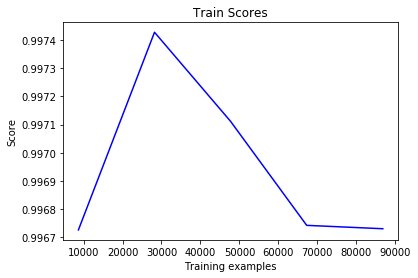

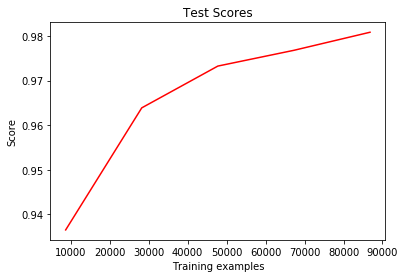

In [104]:
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

train_sizes,train_scores,test_scores = learning_curve(forest, X, np.ravel(Y),cv=cv)
plt.figure()
plt.title('Train Scores')
plt.plot(train_sizes, np.mean(train_scores,axis=1), color = 'b')
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.show()
plt.title('Test Scores')
plt.plot(train_sizes, np.mean(test_scores,axis=1),color='r')
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.show()


In [55]:
domain_df = domain_df.merge(labels)

In [56]:
domain_df

,indicator,domain_name,domain_title,unsafe
0,config01.homepc.it,dyndns.it,dyndns.it,1
1,config01.homepc.it,impulso.it,impulso.it,1
2,config01.homepc.it,ns0.it,ns0.it,1
3,config01.homepc.it,dyndns.it,dyndns.it,1
4,config01.homepc.it,impulso.it,impulso.it,1
5,config01.homepc.it,ns0.it,ns0.it,1
6,config01.homepc.it,dyndns.it,dyndns.it,1
7,config01.homepc.it,impulso.it,impulso.it,1
8,config01.homepc.it,ns0.it,ns0.it,1
9,ing.com,ingfi.com,ingfi.com,1


In [58]:
ind_to_name = []
for i in range(len(domain_df['unsafe'])):
    ind_to_name.append(nltk.edit_distance(domain_df['indicator'][i],domain_df['domain_name'][i]))
domain_df['ind_to_dom_name'] =ind_to_name
domain_df

,indicator,domain_name,domain_title,unsafe,ind_to_dom_name
0,config01.homepc.it,dyndns.it,dyndns.it,1,14
1,config01.homepc.it,impulso.it,impulso.it,1,13
2,config01.homepc.it,ns0.it,ns0.it,1,13
3,config01.homepc.it,dyndns.it,dyndns.it,1,14
4,config01.homepc.it,impulso.it,impulso.it,1,13
5,config01.homepc.it,ns0.it,ns0.it,1,13
6,config01.homepc.it,dyndns.it,dyndns.it,1,14
7,config01.homepc.it,impulso.it,impulso.it,1,13
8,config01.homepc.it,ns0.it,ns0.it,1,13
9,ing.com,ingfi.com,ingfi.com,1,2
